In [23]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [60]:
# 2d Rosenbrock function
def f(x, a=1.0, b=100.0):
    '''
    x: array of row vector of size 2
    '''
    return (a - x[:,0])**2 + b * (x[:,1] - x[:,0]**2)**2

def df(x, a=1.0, b=100.0):
    '''
    for 2d x
    '''
    dx1 = -2*(a-x[:,0]) - 4*b*x[:,0] * (x[:,1]-x[:,0]**2)
    dx2 = 2*b*(x[:,1] - x[:,0]**2)
    return torch.tensor([dx1, dx2]).unsqueeze(0)

def hf(x, a=1.0, b=100.0):
    dx11 = 2 - 4*b*x[:,1] + 12*b*x[:,0]
    dx12 = -4*b*x[:,0]
    dx22 = 2*b
    return torch.tensor([[dx11, dx12],[dx12, dx22]])

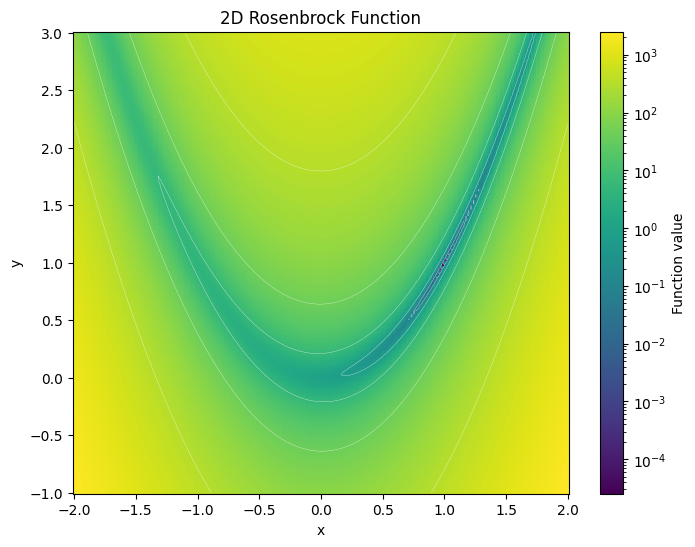

In [61]:
grid_size = 200
x1 = np.linspace(-2, 2, grid_size)
x2 = np.linspace(-1, 3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)

y = f(x).reshape((grid_size,grid_size))

fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolor(X1, X2, y, norm=colors.LogNorm(vmin=y.min(), vmax=y.max()))
contour_levels = np.logspace(np.log10(y.min()), np.log10(y.max()), 10)
contours = ax.contour(X1, X2, y, levels=contour_levels, colors='white', linewidths=0.2)
# ax.clabel(contours, inline=True, fontsize=8)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Function value')
ax.set_title('2D Rosenbrock Function')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [142]:

def adam(f, x0, **f_args):
    hparams = f_args['opt_args']
    optim = torch.optim.Adam([x0], lr=hparams['learning_rate'])
    x_list = []
    x_copy = x0.squeeze().detach().numpy()
    x_list.append(x_copy)
    for j in range(hparams['epochs']):
        optim.zero_grad()

        loss = f(x0.unsqueeze(0))
        loss.backward()

        optim.step()
        x_copy = x0.clone().squeeze().detach().numpy()
        x_list.append(x_copy)
    
    return np.array(x_list)


In [128]:
def NCG(f, x0, max_iter, diff, hess, **f_args):
    """
    Non-linear CG for minimizing the SmoothFn.
    x0: initial guess as a row vector
    """
    tol = f_args['opt_args']['tol']
    NR_max_iter = f_args['opt_args']['NR_max_iter']
    NR_tol = f_args['opt_args']['NR_tol']
    recompute = f_args['opt_args']['recompute']
    
    x_list = []
    x = x0.unsqueeze(0)
    x_copy = x.squeeze().detach().numpy()
    x_list.append(x_copy)
    k = 0
    r = -diff(x).T # r should be column vector
    d = r
    delta_new = (r.T@r).item()
    tolerance = tol**2 * delta_new # when ||r_i|| <= tol * ||r_0||
    num_iter = max_iter
    for i in range(max_iter):
        delta_d = d.T@d
        for j in range(NR_max_iter): # newton-ralph approximation
            hessian = hess(x)

            denom = d.T@hessian@d
            if i == 0:
                assert denom != 0, "try a new starting point"
            elif denom == 0:
                d = r = -diff(x).T
                x=x0.unsqueeze(0)
                break
            alpha = -(diff(x)@d / denom).item()
            x = x + alpha*d.squeeze()
            if alpha**2 * delta_d <= NR_tol:
                break
        x_copy = x.squeeze().detach().numpy()
        x_list.append(x_copy)
        r = -diff(x).T
        delta_old = delta_new
        delta_new = r.T@r
        beta = delta_new/delta_old
        d = r + beta*d
        if k>=recompute or r.T@d <=0: # restart whenever a search direction is computed that is not descent direction
            k = 0
            d = r

        if delta_new <= tolerance:
            num_iter = i+1
            print("Converged at ", i+1)
            break
        
    return x, r, num_iter, np.array(x_list)



In [156]:
hparams = {'epochs': 500,
           'tol': 1e-6, # tolerance for CG
           'learning_rate': 1e-3,
           'NR_max_iter': 200, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 50, # recompute the exact residual every n iterations
           }

# --------------- run optimization
max_iter = hparams['epochs']
x = torch.tensor([0.0, 2.0]).requires_grad_(True)
x, _, _, x_list = NCG(f, x, max_iter, df, hf, opt_args=hparams)

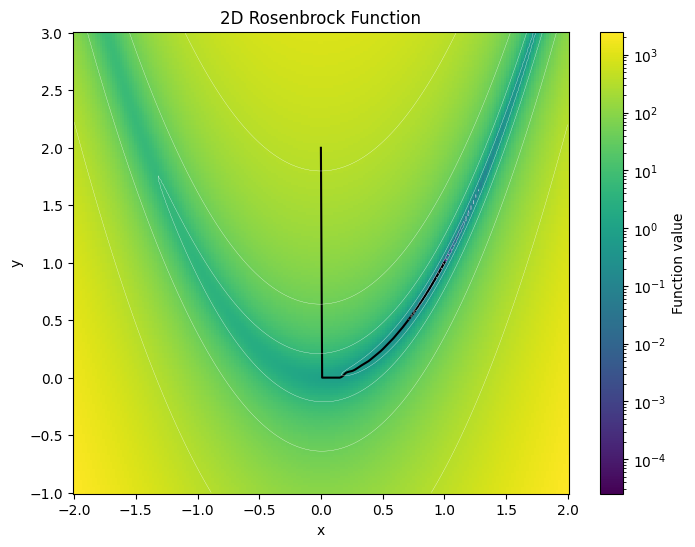

In [157]:

fig, ax = plt.subplots(figsize=(8, 6))
line1, = ax.plot(x_list[:,0], x_list[:,1], color='black', label='CG Trajectory')
pcm = ax.pcolor(X1, X2, y, norm=colors.LogNorm(vmin=y.min(), vmax=y.max()))
contour_levels = np.logspace(np.log10(y.min()), np.log10(y.max()), 10)
contours = ax.contour(X1, X2, y, levels=contour_levels, colors='white', linewidths=0.2)
# ax.clabel(contours, inline=True, fontsize=8)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Function value')
ax.set_title('2D Rosenbrock Function')
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.legend(handles=[line1])

plt.show()

In [154]:
x = torch.tensor([0.0, 2.0]).requires_grad_(True)
gd_list = adam(f, x, opt_args=hparams)


(501, 2)


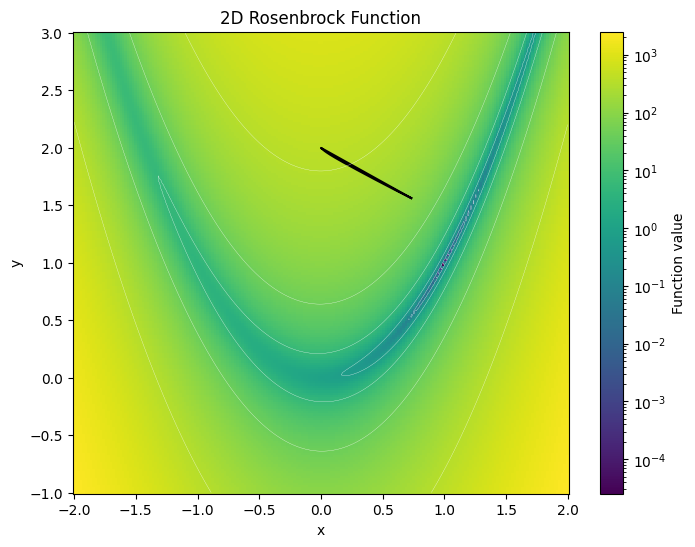

In [155]:
print(gd_list.shape)
fig, ax = plt.subplots(figsize=(8, 6))
line1, = ax.plot(gd_list[:,0], gd_list[:,1],color='black', label='CG Trajectory')
pcm = ax.pcolor(X1, X2, y, norm=colors.LogNorm(vmin=y.min(), vmax=y.max()))
contour_levels = np.logspace(np.log10(y.min()), np.log10(y.max()), 10)
contours = ax.contour(X1, X2, y, levels=contour_levels, colors='white', linewidths=0.2)
# ax.clabel(contours, inline=True, fontsize=8)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Function value')
ax.set_title('2D Rosenbrock Function')
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.legend(handles=[line1])

plt.show()